# Input Data Preparation

## Installations & Imports

### Installations

In [4]:
import sys

In [105]:
%load_ext autoreload
%autoreload 2

### Imports

In [5]:
from PIL import Image
from pathlib import Path as Data_Path
from os import listdir
from os.path import isfile, join
from datetime import datetime

import collections
import numpy as np
import random
import gc
import matplotlib.pyplot as plt
import seaborn as sn
from IPython.display import SVG

import tensorflow as tf
import tensorboard
from tensorflow import keras
from sklearn.utils import class_weight
from sklearn.preprocessing import normalize

from sklearn.metrics import confusion_matrix
from cf_matrix import make_confusion_matrix

### Initialization

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [50]:
gc.collect()

33

In [3]:
%matplotlib inline

In [5]:
%reload_ext tensorboard

## Data Loading

In [7]:
DATA_PATH = Data_Path("/Volumes/LaCie/Building_Damage_Assessment")
DATA_PATH.exists()

True

In [8]:
hurricanes = ['hurricane-florence', 'hurricane-harvey', 'hurricane-matthew', 'hurricane-michael']

In [68]:
TRAIN_IMAGE_PATH = join(DATA_PATH, 'test', 'images')
TRAIN_LABEL_PATH = join(DATA_PATH, 'test', 'labels')
TRAIN_INPUT_PATH = join(DATA_PATH, 'test', 'resized_images_224', hurricanes[3] + '-post')

In [69]:
TRAIN_INPUT_PATH

'/Volumes/LaCie/Building_Damage_Assessment/test/resized_images_224/hurricane-michael-post'

In [70]:
Data_Path(TRAIN_INPUT_PATH).exists()

True

In [71]:
input_image_names = [f for f in listdir(TRAIN_INPUT_PATH) if isfile(join(TRAIN_INPUT_PATH, f))]
len(input_image_names)

5657

In [55]:
def get_labels(file_names):
    return np.array([f.split('_')[-1].split('.')[0] for f in file_names])

In [56]:
def get_label_stats(labels):
    label_count = collections.Counter(labels)
    # printing the element and the frequency
    for key, value in label_count.items():
       print(f"{key}: {(value * 100) / len(labels)}%")

In [72]:
random.shuffle(input_image_names)

In [73]:
image_sample_names = input_image_names #random.sample(input_image_names, 16000)
image_sample_labels = get_labels(image_sample_names)

In [74]:
get_label_stats(image_sample_labels)

no-damage: 64.46879971716457%
major-damage: 7.229980555064522%
minor-damage: 24.094042778858054%
destroyed: 3.2349301750044193%
un-classified: 0.9722467739084321%


In [75]:
image_labels = get_labels(input_image_names)

In [76]:
get_label_stats(image_labels)

no-damage: 64.46879971716457%
major-damage: 7.229980555064522%
minor-damage: 24.094042778858054%
destroyed: 3.2349301750044193%
un-classified: 0.9722467739084321%


## Image Processing

In [41]:
def load_images(image_name_array, path):
    """
    :param image_name_array: array of image file names
    :param path: the directory to load the data from
    :returns: all images as a numpy array
    """
    concat_file_names = [join(path, name) for name in image_name_array]
    images = np.array([np.array(Image.open(fname)) for fname in concat_file_names])
    print('Loaded Number of Images:', len(images))
    
    if len(images) == 0:
        return
    print('First Image Dimension: {}px x {}px'.format(images[0].shape[0], images[0].shape[1]))
    return images

In [42]:
def get_softmax_labels(labels):
    """
    :param labels: array of sparse labels to convert to softmax labels
    :returns: 
    """
    softmax_labels = np.zeros((labels.shape[0], 4))

    for i in range(len(labels)):
        softmax_labels[i, labels[i]] = 1
        
    return softmax_labels

In [43]:
def encode_labels(labels, sparse=True):
    """
    :param labels: array of string labels
    :param spars: whether the output of the encoded labels should be sparse
    :returns: numpy array of encoded labels (softmax vector)
    """
    
    def _encode_single_label(label):
        if label == 'no-damage':
            return 0
        elif label == 'minor-damage':
            return 1
        elif label == 'major-damage':
            return 2
        elif label == 'destroyed':
            return 3
        else:
            return 0
    
    encoded_labels = np.array([_encode_single_label(l) for l in labels]).reshape((-1, 1))
    
    if sparse:
        return encoded_labels

    return get_softmax_labels(encoded_labels)

In [77]:
input_images = load_images(image_sample_names, TRAIN_INPUT_PATH)

Loaded Number of Images: 5657
First Image Dimension: 224px x 224px


In [78]:
input_images.shape

(5657, 224, 224, 3)

In [89]:
def subtract_mean_rgb(images):
    """
    :param images: a numpy array of images
    :returns: images from which the mean pixel values (rgb) have been subtracted
    """
    n, w, h, c = images.shape
    reshaped_images = images.reshape((n, w*h, c))
    means = np.mean(reshaped_images, axis=1)
    reshaped_images = reshaped_images - means.reshape((n, -1, 3))
    return reshaped_images.reshape((n, w, h, c))

In [90]:
def normalize_images(images):
    """
    :param images: a numpy array of images
    :returns: noralized images
    """
    return images / 255.

In [14]:
def transform_input_data(images):
    """
    :param images: numpy array of images to be scaled to a [0, 1] range
    :returns: transformed image data
    """
    max_value = np.max(images)
    min_value = np.min(images)
    range_value = max_value - min_value
    return (images - min_value) / range_value

In [21]:
def display_image(image):
    """
    :param image: the image as a numpy array to be displayed
    """
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(image)

In [91]:
input_images = normalize_images(input_images)

In [92]:
input_images = subtract_mean_rgb(input_images)

In [ ]:
input_images = transform_input_data(input_images)

In [214]:
input_images.shape

(13939, 64, 64, 3)

In [79]:
encoded_labels = encode_labels(image_sample_labels, sparse=False)

In [80]:
encoded_labels.shape

(5657, 4)

In [81]:
encoded_labels[0]

array([1., 0., 0., 0.])

In [224]:
train_index_cut = int(len(encoded_labels) * 0.8)
train_index_cut

11151

In [225]:
x_train, x_test = (input_images[:train_index_cut], input_images[train_index_cut:])
y_train, y_test = (encoded_labels[:train_index_cut], encoded_labels[train_index_cut:])

In [58]:
x_val = input_images[train_index_cut:2*train_index_cut]
y_val = encoded_labels[train_index_cut:2*train_index_cut]

In [226]:
print("Train Data Stats:")
get_label_stats(image_sample_labels[:train_index_cut])

Train Data Stats:
no-damage: 17.97148237826204%
un-classified: 5.5690072639225185%
major-damage: 14.196036229934535%
destroyed: 15.343915343915343%
minor-damage: 46.91955878396556%


In [236]:
def naive_accuracy(labels):
    label_count = collections.Counter(labels)
    counts = [value for _, value in label_count.items()]
    maximum_value = np.max(counts)
    return maximum_value / len(labels)

In [82]:
get_label_stats(image_sample_labels)

major-damage: 1902
no-damage: 14588
minor-damage: 5207
destroyed: 757
un-classified: 232


In [83]:
14588 / len(image_sample_labels)

0.6430397602045315

In [235]:
label_count = collections.Counter(image_sample_labels)
label_count.items()

dict_items([('no-damage', 2515), ('un-classified', 784), ('major-damage', 1945), ('destroyed', 2147), ('minor-damage', 6548)])

In [237]:
naive_accuracy(image_sample_labels)

0.46976110194418536

In [ ]:
print("Test Data Stats:")
get_label_stats(image_sample_labels[train_index_cut:])

### Save & Load Data

In [25]:
np.savez_compressed('raw_{}.npz'.format(hurricanes[3]), input_images=input_images, input_labels=encoded_labels, image_names=input_image_names)

In [82]:
np.savez_compressed('holdout_{}.npz'.format(hurricanes[3]), input_images=input_images, input_labels=encoded_labels, image_names=input_image_names)

In [17]:
input_data = np.load('processed_hurricane_michael.npz')

In [19]:
x_train, y_train = input_data['x_train'], input_data['y_train']
x_test, y_test = input_data['x_test'], input_data['y_test']

In [29]:
x_train.shape

(18148, 64, 64, 3)

## Build Models

In [38]:
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras import layers
from keras import losses, metrics, optimizers
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import keras.backend as K
K.set_image_data_format('channels_last')

In [39]:
from keras.applications import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input as resnet_preprocess

In [40]:
x_train.shape

(18148, 64, 64, 3)

In [41]:
y_train.shape, y_test.shape

((18148, 1), (4538, 1))

### Test Model

In [105]:
def TestModel():
    """
    Implementation of the TestModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset
        (height, width, channels) as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(shape=(200, 200, 3))

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (5, 5), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL -> DROPOUT
    X = MaxPooling2D((2, 2), name='max_pool0')(X)
    X = Dropout(.3)(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(64, (3, 3), strides = (1, 1), padding='same', name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool1')(X)
    X = Dropout(.3)(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(128, (3, 3), strides = (1, 1), padding='same', name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool2')(X)
    X = Dropout(.3)(X)
    
    # CONV -> BN -> RELU Block applied to X
    #X = Conv2D(256, (3, 3), strides = (1, 1), padding='same', name = 'conv3')(X)
    #X = BatchNormalization(axis = 3, name = 'bn3')(X)
    #X = Activation('relu')(X)
    
    # MAXPOOL
    #X = MaxPooling2D((2, 2), name='max_pool3')(X)
    #X = Dropout(.3)(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(64, activation='relu', name='fc-0')(X)
    X = Dropout(.5)(X)
    X = Dense(16, activation='relu', name='fc-1')(X)
    X = Dropout(.2)(X)
    X = Dense(4, activation='softmax', name='fc-softmax')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='TestModel')
    
    return model

In [106]:
# Create Model
test_model = TestModel()

In [107]:
# Choose Optimizer
loss = losses.categorical_crossentropy
optimizer = optimizers.Adam(learning_rate=0.001)
test_model.compile(optimizer=optimizer, loss=loss, metrics=['AUC', 'categorical_accuracy', 'accuracy'])

In [108]:
batch_size = int(x_train.shape[0] * 0.05)
batch_size

907

In [109]:
test_model.summary()

Model: "TestModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 204, 204, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 200, 200, 32)      2432      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 200, 200, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 200, 200, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 100, 100, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 32)      0 

### Resnet50v2

In [110]:
new_input = Input(shape=(64, 64, 3))

In [111]:
base_model = ResNet50V2(include_top=False, weights='imagenet', input_tensor=new_input)

In [138]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# add a fully-connected layer
#x = Dense(32, activation='relu')(x)

# and a logistic layer -- let's say we have 4 classes
predictions = Dense(4, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['AUC', 'categorical_accuracy', 'accuracy'])

In [139]:
batch_size = int(x_train.shape[0] * 0.05) + 1
batch_size

908

In [140]:
model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
______________________________________________________________________________________

## Baseline Model Training

### Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression

In [41]:
clf = LogisticRegression(penalty='l2', tol=1e-3, class_weight='balanced', solver='saga', 
                         max_iter=1000, multi_class='multinomial', random_state=0)

In [42]:
x_train.shape

(18148, 64, 64, 3)

In [43]:
y_train.shape

(18148, 1)

In [44]:
x_train_flat = x_train.reshape((x_train.shape[0], -1))

In [45]:
x_train_flat.shape

(18148, 12288)

In [46]:
clf.fit(x_train_flat, y_train.flatten())

LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', random_state=0, solver='saga',
                   tol=0.001)

### SVM

In [5]:
from sklearn.svm import SVC

In [6]:
clf = SVC(C=1.0, kernel='rbf', tol=0.001, cache_size=500, class_weight='balanced', verbose=True, max_iter=-1, 
          decision_function_shape='ovr', break_ties=False, random_state=0)

In [7]:
x_train.shape

(18148, 64, 64, 3)

In [8]:
y_train.shape

(18148, 1)

In [9]:
x_train_flat = x_train.reshape((x_train.shape[0], -1))

In [10]:
x_train_flat.shape

(18148, 12288)

In [11]:
clf.fit(x_train_flat, y_train.flatten())

[LibSVM]

SVC(cache_size=500, class_weight='balanced', random_state=0, verbose=True)

### Predict

In [17]:
def get_image(fname):    
    """
    :param fname: a filepath to the image
    :returns: the image in ndarray format
    """
    return np.array(Image.open(fname))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


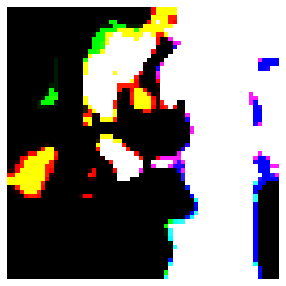

In [20]:
index = 210
plt.figure(figsize=(5,5))
plt.axis('off')
#print(image_sample_names[index])
#img = get_image(join(TRAIN_INPUT_PATH, image_sample_names[index]))
plt.imshow(x_test[index] * 255)

In [48]:
x_test_flat = x_test.reshape((x_test.shape[0], -1))

In [22]:
clf.predict(x_test_flat[index].reshape(1, -1))

array([3])

In [49]:
predictions = clf.predict(x_test_flat)

In [50]:
predictions.shape

(4538,)

In [25]:
np.savez_compressed('svm_predictions_test_hurricane_matthew.npz', predictions=predictions)

In [26]:
y_test.flatten()

array([1, 0, 1, ..., 2, 0, 0])

In [51]:
sum(predictions == y_test.flatten()) / len(y_test)

0.37968267959453506

### CNN Training

In [ ]:
classes = np.argmax(y_train, axis=-1)
classes

In [ ]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(classes), classes)
class_weights = dict(enumerate(class_weights))
class_weights

In [ ]:
# Tensorboard Logging
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, update_freq='batch')

In [320]:
%tensorboard --logdir logs/scalars

Reusing TensorBoard on port 6006 (pid 1506), started 6:21:27 ago. (Use '!kill 1506' to kill it.)

In [ ]:
# Train Model
training_history = test_model.fit(x_train, y_train, batch_size=batch_size, epochs=1, class_weight=class_weights, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])

In [55]:
print("Average test accuracy: ", np.mean(training_history.history['val_accuracy']))

NameError: name 'training_history' is not defined

### Resnet Training

#### Model Specific Preprocessing

In [141]:
classes = y_train.flatten()
classes

array([0, 0, 0, ..., 0, 1, 0])

In [142]:
x_train_res = resnet_preprocess(x_train)
x_test_res = resnet_preprocess(x_test)

In [143]:
y_train_res = get_softmax_labels(y_train)
y_test_res = get_softmax_labels(y_test)

#### Models

In [144]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(classes), classes)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.3814207650273224,
 1: 1.099079457364341,
 2: 2.9848684210526315,
 3: 7.499173553719008}

In [145]:
# Tensorboard Logging
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, update_freq='batch')

In [146]:
%tensorboard --logdir logs/scalars

In [147]:
model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
______________________________________________________________________________________

In [148]:
# Train Model
training_history = model.fit(x_train_res, y_train_res, batch_size=batch_size, epochs=10, class_weight=class_weights, validation_data=(x_test_res, y_test_res), callbacks=[tensorboard_callback])

Epoch 1/10
20/20 [==============================] - 200s 10s/step - loss: 1.3972 - auc: 0.5513 - categorical_accuracy: 0.3054 - accuracy: 0.3054 - val_loss: 1.4088 - val_auc: 0.2370 - val_categorical_accuracy: 0.2378 - val_accuracy: 0.2378
Epoch 2/10
20/20 [==============================] - 209s 10s/step - loss: 1.3875 - auc: 0.4867 - categorical_accuracy: 0.2426 - accuracy: 0.2426 - val_loss: 1.4018 - val_auc: 0.4911 - val_categorical_accuracy: 0.0335 - val_accuracy: 0.0335
Epoch 3/10
20/20 [==============================] - 212s 11s/step - loss: 1.3883 - auc: 0.5144 - categorical_accuracy: 0.2120 - accuracy: 0.2120 - val_loss: 1.4599 - val_auc: 0.4069 - val_categorical_accuracy: 0.0335 - val_accuracy: 0.0335
Epoch 4/10
20/20 [==============================] - 222s 11s/step - loss: 1.3888 - auc: 0.4900 - categorical_accuracy: 0.2436 - accuracy: 0.2436 - val_loss: 1.4142 - val_auc: 0.3214 - val_categorical_accuracy: 0.0842 - val_accuracy: 0.0842
Epoch 5/10
20/20 [======================

In [128]:
print("Average test accuracy: ", np.mean(training_history.history['val_accuracy']))

Average test accuracy:  0.11811370402574539


## Evaluation

In [28]:
from sklearn.metrics import balanced_accuracy_score

In [29]:
from sklearn.metrics import roc_auc_score

In [52]:
balanced_accuracy_score(y_test.flatten(), predictions)

0.3592570072916603

In [53]:
def to_one_hot(labels):
    one_hot_labels = np.zeros((labels.shape[0], 4))
    for i in range(len(labels)):
        one_hot_labels[i][labels[i]] = 1
    return one_hot_labels

In [54]:
predictions

array([1, 0, 0, ..., 1, 3, 0])

In [55]:
predictions_one_hot = to_one_hot(predictions)

In [56]:
y_test_one_hot = to_one_hot(y_test.flatten())

In [57]:
roc_auc_score(y_test_one_hot, predictions_one_hot, multi_class='ovo')

0.5657424962560484

In [36]:
naive_predictions = np.zeros((len(predictions)), dtype=np.int32)

In [37]:
balanced_accuracy_score(y_test.flatten(), naive_predictions)

0.25

In [38]:
roc_auc_score(y_test_one_hot, to_one_hot(naive_predictions))

0.5

## Save & Load Model

In [155]:
# Calling `save('my_model')` creates a SavedModel folder `my_model`.
test_model.save("test_model_weighted")

# It can be used to reconstruct the model identically.
#reconstructed_model = keras.models.load_model("test_model")

INFO:tensorflow:Assets written to: test_model_weighted/assets


In [13]:
from joblib import dump, load

In [47]:
dump(clf, 'log_reg_hurricane_michael_0.8_train_1000iter_1e-3tol.joblib') 

['log_reg_hurricane_michael_0.8_train_1000iter_1e-3tol.joblib']

In [14]:
dump(clf, 'SVM_hurricane_michael_0.8_train_-1iter_rbf_1e-3tol.joblib') 

['SVM_hurricane_michael_0.8_train_-1iter_rbf_1e-3tol.joblib']

In [50]:
clf = load('log_reg_hurricane_michael_0.8_train_200iter_1e-3tol.joblib')

/Users/lukashaas/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/lukashaas/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.21.3 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Interpretation

In [ ]:
scale = np.max(np.abs(clf.coef_))

p = plt.figure(figsize=(25, 2.5));

for i in range(nclasses):
    p = plt.subplot(1, nclasses, i + 1)
    p = plt.imshow(clf.coef_[i].reshape(28, 28),
                  cmap=plt.cm.RdBu, vmin=-scale, vmax=scale);
    p = plt.axis('off')
    p = plt.title('Class %i' % i);

## Evaluation

In [322]:
predictions = test_model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=-1)

In [323]:
true_classes = np.argmax(y_test, axis=-1)

In [324]:
unique, counts = np.unique(true_classes, return_counts=True)
dict(zip(unique, counts))

{0: 386, 1: 80, 2: 317, 3: 17}

In [326]:
unique, counts = np.unique(predicted_classes, return_counts=True)
dict(zip(unique, counts))

{0: 800}

In [327]:
cf_matrix = confusion_matrix(true_classes, predicted_classes)
cf_matrix

array([[386,   0,   0,   0],
       [ 80,   0,   0,   0],
       [317,   0,   0,   0],
       [ 17,   0,   0,   0]])

In [160]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 10

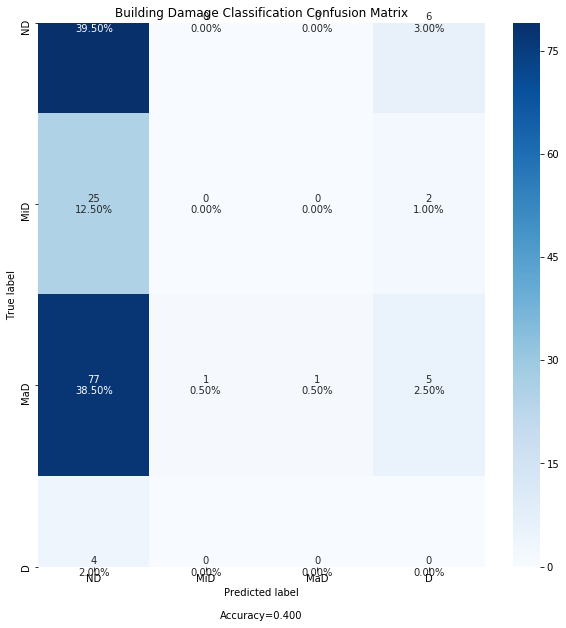

In [161]:
#plt.figure(figsize=(10,7))
categories = ['ND', 'MiD', 'MaD', 'D']
make_confusion_matrix(cf_matrix, categories=categories, title='Building Damage Classification Confusion Matrix')

## Visualize

In [79]:
destroyed_image_indices = [i for i, x in enumerate(image_sample_names) if '_destroyed' in x]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


hurricane-michael_00000112_post_disaster_00fcdd2a-9062-411a-a308-0c9f3f849313_destroyed.png


<Figure size 216x216 with 0 Axes>

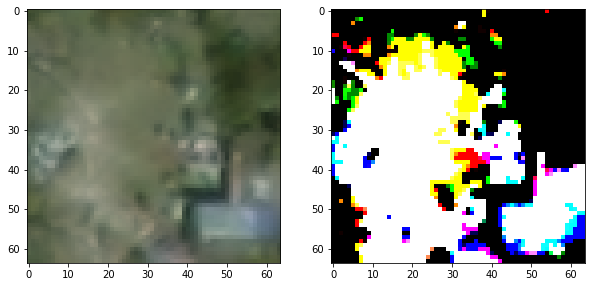

In [104]:
plt.figure(figsize=(3,3))
random_index = np.random.choice(destroyed_image_indices) # randint(0, len(image_sample_names))
print(image_sample_names[random_index])

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(get_image(join(TRAIN_INPUT_PATH, image_sample_names[random_index])))
fig.add_subplot(1, 2, 2)
plt.imshow(input_images[random_index] * 255)

In [159]:
model_to_dot(test_model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [154]:
plot_model(test_model, to_file='TestModel.png')
SVG(model_to_dot(test_model).create(prog='dot', format='svg'))

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


AttributeError: 'NoneType' object has no attribute 'create'